Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5521 - auc: 0.5709 - loss: 0.8497 - val_accuracy: 0.5931 - val_auc: 0.6352 - val_loss: 0.6773 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6063 - auc: 0.6221 - loss: 0.7312 - val_accuracy: 0.6407 - val_auc: 0.6763 - val_loss: 0.6519 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6475 - auc: 0.6817 - loss: 0.6507 - val_accuracy: 0.6537 - val_auc: 0.6908 - val_loss: 0.6387 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6379 - auc: 0.6908 - loss: 0.6409 - val_accuracy: 0.6623 - val_auc: 0.7063 - val_loss: 0.6275 - learning_rate: 0.0010
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6753 - auc: 0.7485 - loss: 0.5922 - val_accuracy: 0.6623 - val_auc: 0.7080 - val_loss: 0.6213 - learning_rate: 0.0010
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6506 - auc: 0.7217 

Test Accuracy: 0.6970
Test AUC: 0.7949
Model saved as diabetes_ann_model.h5


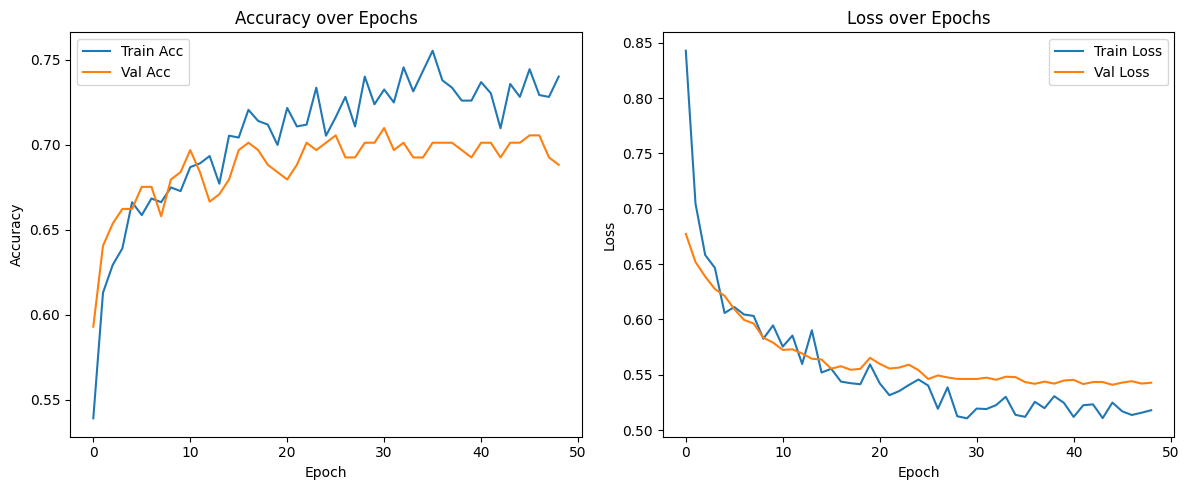

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


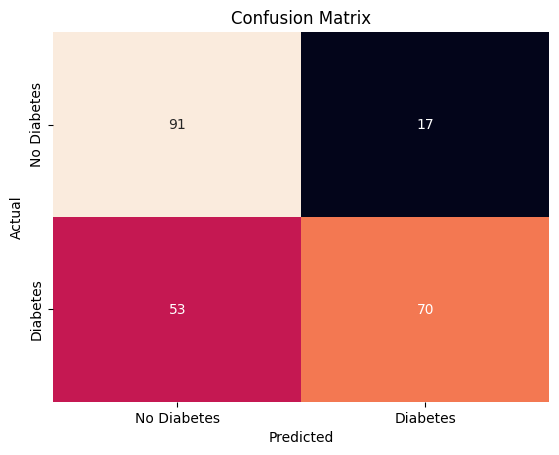

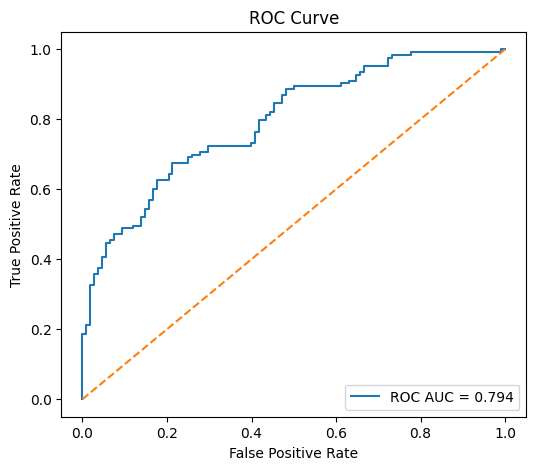

              precision    recall  f1-score   support

 No Diabetes       0.63      0.84      0.72       108
    Diabetes       0.80      0.57      0.67       123

    accuracy                           0.70       231
   macro avg       0.72      0.71      0.69       231
weighted avg       0.72      0.70      0.69       231



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

df = pd.read_csv("/content/diabetics.csv")
df.rename(columns={
    'a': 'Pregnancies',
    'b': 'Glucose',
    'c': 'BloodPressure',
    'd': 'SkinThickness',
    'e': 'Insulin',
    'f': 'BMI',
    'g': 'DiabetesPedigreeFunction',
    'h': 'Age',
    'outcome': 'Outcome'
}, inplace=True)


for col in ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]:
    df[col] = df[col].replace(0, np.nan)
    df[col] = df[col].fillna(df[col].median())

X = df.drop("Outcome", axis=1).values.astype(np.float32)
y = df["Outcome"].values.astype(np.float32)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
cls_weights = dict(zip(np.unique(y_train), weights))


model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)


early_stop = callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=cls_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC: {auc:.4f}")


model.save("diabetes_ann_model.h5")
print("Model saved as diabetes_ann_model.h5")


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy over Epochs"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss over Epochs"); plt.legend()
plt.tight_layout()
plt.show()


y_prob = model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=["No Diabetes","Diabetes"], yticklabels=["No Diabetes","Diabetes"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve"); plt.legend(loc="lower right")
plt.show()


print(classification_report(y_test, y_pred, target_names=["No Diabetes","Diabetes"]))
